In [1]:
# https://bigquery.cloud.google.com/dataset/the-psf:pypi

%matplotlib inline

import os
import io
import json
import functools

import pandas as pd
import pandas_gbq  # pip install "pandas-gbq>=0.2,<0.5"

CRED_KW = {'token', 'refresh_token', 'id_token', 'token_uri', 'client_id', 'client_secret'}

PROJECT_ID = 'scripting-148608'

def load_credentials(filename, scopes):
    from google.oauth2.credentials import Credentials
    if os.path.exists(filename):
        with io.open(filename, 'rb') as f:
            kwargs = json.load(f)
        kwargs['token'] = kwargs.pop('access_token')
        kwargs = {k: v for k, v in kwargs.items() if k in CRED_KW}
        return Credentials(**kwargs, scopes=scopes)

def save_credentials(creds, filename):
    doc = {k: getattr(creds, k) for k in (CRED_KW - {'token'})}
    doc['access_token'] = creds.token
    with io.open(filename, 'w') as f:
        json.dump(doc, f)
    
def get_credentials(scopes, secrets='~/client_secrets.json', storage='~/storage.json'):
    creds = load_credentials(os.path.expanduser(storage), scopes)
    if creds is None:
        from google_auth_oauthlib.flow import InstalledAppFlow
        flow = InstalledAppFlow.from_client_secrets_file(os.path.expanduser(secrets), scopes)
        flow.run_local_server()
        creds = flow.credentials
        save_credentials(creds, os.path.expanduser(storage))
    return creds

class GbqConnector(pandas_gbq.gbq.GbqConnector):

    def get_user_account_credentials(self):
        return get_credentials(self.scope)

pandas_gbq.gbq.GbqConnector = GbqConnector  # monkey patch

read_gbq = functools.partial(pd.io.gbq.read_gbq, dialect='standard', project_id=PROJECT_ID)

In [2]:
RESULT, START, END = 'pypi.csv', '20181101', '20181231'

PROJECTS = (
    'graphviz', 'features', 'concepts', 'bitsets', 'fileconfig',
    'gsheets', 'latexpages', 'dmengine', 'current', 'csv23',
)

QUERY ='''SELECT
  EXTRACT(YEAR FROM timestamp) AS year, EXTRACT(MONTH FROM timestamp) AS month,
  file.project AS project, file.version AS version, file.type AS type,
  country_code AS country,
  REGEXP_EXTRACT(details.python, r'^([^\.]+\.[^\.]+)') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `the-psf.pypi.downloads*`
WHERE _TABLE_SUFFIX BETWEEN '%s' AND '%s' AND file.project IN %r
GROUP BY year, month, project, version, type, country, python, system''' % (START, END, PROJECTS)

if not os.path.exists(RESULT):
    _df = read_gbq(QUERY)
    _df.to_csv(RESULT, index=False, encoding='utf-8')

INDEX = ['year', 'month', 'project', 'version', 'type', 'country', 'python', 'system']
ASC = [i not in ('year', 'month') for i in INDEX]
    
_df = pd.read_csv(RESULT, encoding='utf-8')\
    .sort_values(by=INDEX, ascending=ASC).reset_index(drop=True)
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 9 columns):
year         0 non-null object
month        0 non-null object
project      0 non-null object
version      0 non-null object
type         0 non-null object
country      0 non-null object
python       0 non-null object
system       0 non-null object
downloads    0 non-null object
dtypes: object(9)
memory usage: 76.0+ bytes


In [3]:
ARCHIVE = 'pypi_archive.csv'

_af = pd.read_csv(ARCHIVE, encoding='utf-8')\
    .sort_values(by=INDEX, ascending=ASC).reset_index(drop=True)

_cf = pd.concat([_af, _df]).sort_values(by=INDEX, ascending=ASC).reset_index(drop=True)

_cf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179803 entries, 0 to 179802
Data columns (total 9 columns):
year         179803 non-null object
month        179803 non-null object
project      179803 non-null object
version      179803 non-null object
type         179803 non-null object
country      170473 non-null object
python       69683 non-null float64
system       62993 non-null object
downloads    179803 non-null object
dtypes: float64(1), object(8)
memory usage: 12.3+ MB


In [4]:
df = _cf.fillna('N/A')
df.head()

,year,month,project,version,type,country,python,system,downloads
0,2018,10,bitsets,0.1,sdist,AE,N/A,N/A,1
1,2018,10,bitsets,0.1,sdist,CA,N/A,N/A,3
2,2018,10,bitsets,0.1,sdist,CN,N/A,N/A,29
3,2018,10,bitsets,0.1,sdist,CZ,N/A,N/A,1
4,2018,10,bitsets,0.1,sdist,DE,N/A,N/A,3


In [5]:
df.pivot_table('downloads', ['year', 'month'], 'project', aggfunc='sum', fill_value=0)

project     bitsets  concepts  csv23  current  dmengine  features  fileconfig  \
year month                                                                      
2016 6         3805      3799      0      654      1244      2286        1360   
     7         3905      3999      0      974      1413      2407        1532   
     8         4494      4505      0     1099      1737      2790        1751   
     9         3989      4158      0     1169      1658      2559        1636   
     10        3156      3002      0      776      1159      1912        1227   
     11        3376      3505      0      622      1133      2040        1188   
     12        2811      2873      0      505       931      1698        1011   
2017 1         3145      3099      0      532       866      1571         940   
     2         2981      3072      0      568      1005      1760        1077   
     3         3649      3889      0      675      1162      2063        1202   
     4         4387      4434      0      850       793      2544        1510   
     5         2946      2632      0     1140      1326      2470        2810   
     6         3001      2911      0      798      1014      1872        1661   
     7         2492      2353      0      653       874      1646        1328   
     8         2433      2415      0      574      1428      1558        1115   
     9         2431      2247      0      570       987      1619        1205   
     10        3163      3257      0      524       936      2282        1998   
     11        3305      3028      0      517       978      2394        1924   
     12        2985      3037      0      670      1192      2208        1776   
2018 1         2227      2390   1081      628       933      1698        1237   
     2         1804      1792    497      372       668      1263         968   
     3         1444      1433    264      263       506      1103         843   
     4         1504      1374    437      321       629      1121         904   
     5         1632      1760    676      421       687      1187         905   
     6         1407      1403    423      283       504       880         791   
     7         1191      1071    308      261       426       859         690   
     8         3885      3719   1012      882      1491      2640        2080   
     9         3415      3407   1011      832      1353      2426        1927   
     10        4402      4331   1077     1362      2020      2974        2645   

project     graphviz  gsheets  latexpages  
year month                                 
2016 6         23462        0        2327  
     7         27466        0        2175  
     8         27825        0        2459  
     9         34277        0        4306  
     10        31108        0        1843  
     11        32904      526        1971  
     12        36357      278        1703  
2017 1         47077      198        1464  
     2         47283      226        1854  
     3         59031      967        3395  
     4         55757      389        1699  
     5         60170      268        1351  
     6         64933      358        1637  
     7         95162      491        1409  
     8        118609     1465        1497  
     9        107230      608        1659  
     10       125717     1351        2251  
     11       112268     3925        1794  
     12       122657      617        2170  
2018 1        155823      490        1777  
     2        116420      437        1131  
     3        143204      362         837  
     4        152365      439         979  
     5        113691      490        1268  
     6        145612      358         874  
     7        116365      584         756  
     8        422729     1693        2331  
     9        397502     1479        2249  
     10       513320     1875        2697

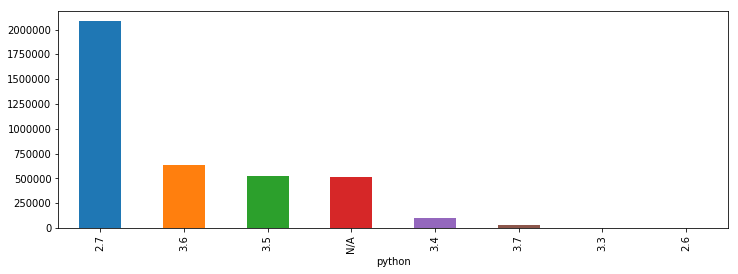

In [6]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False)[:8].plot.bar(figsize=(12, 4));

In [7]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False).to_frame()\
    .apply(lambda x: x / x.sum()).style.format('{:.2%}').set_uuid('6')

,downloads
python,
2.7,53.44%
3.6,16.21%
3.5,13.44%
N/A,13.12%
3.4,2.67%
3.7,0.86%
3.3,0.13%
2.6,0.11%
1.17,0.02%


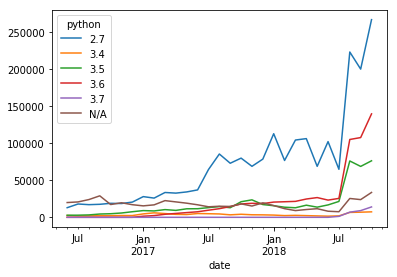

In [8]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .plot();

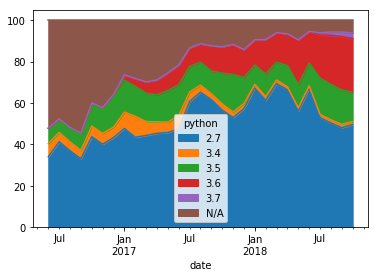

In [9]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .stack().groupby('date').transform(lambda g: 100 * g / g.sum()).unstack()\
    .plot(kind='area');

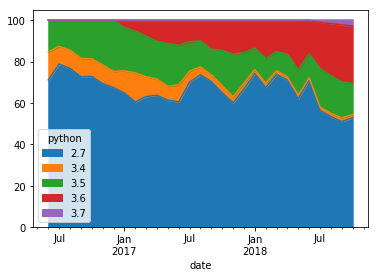

In [10]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .drop('N/A', axis=1).stack().groupby('date').transform(lambda g: 100 * g / g.sum()).unstack()\
    .plot(kind='area');

In [11]:
gf = df[df['project'] == 'graphviz'].drop('project', axis=1)
gf.head()

,year,month,version,type,country,python,system,downloads
4454,2018,10,0.1,sdist,AE,N/A,N/A,1
4455,2018,10,0.1,sdist,BR,3.6,Darwin,1
4456,2018,10,0.1,sdist,CA,N/A,N/A,3
4457,2018,10,0.1,sdist,CN,N/A,N/A,27
4458,2018,10,0.1,sdist,CZ,N/A,N/A,1


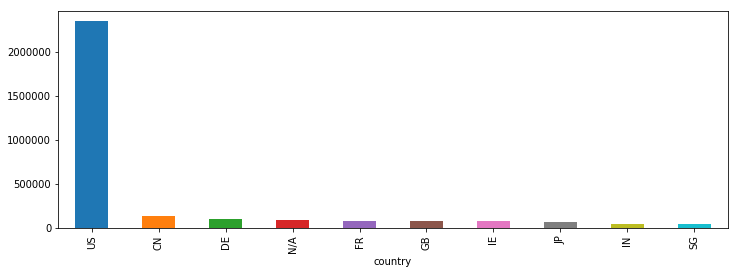

In [12]:
gf.groupby('country')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

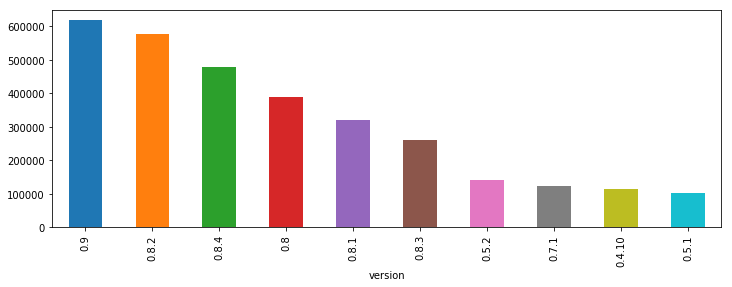

In [13]:
gf.groupby('version')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

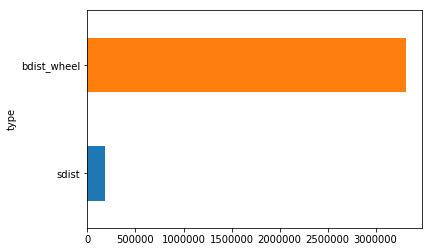

In [14]:
gf.groupby('type')['downloads'].sum().sort_values().plot.barh();

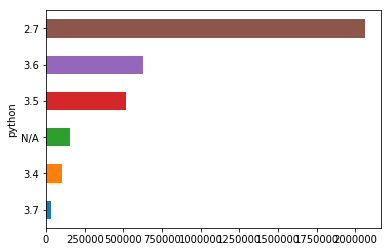

In [15]:
gf.groupby('python')['downloads'].sum().sort_values()[-6:].plot.barh();

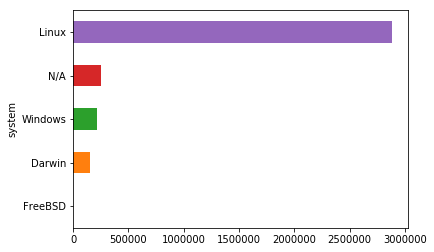

In [16]:
gf.groupby('system')['downloads'].sum().sort_values()[-5:].plot.barh();